![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.Clinical_DeIdentification.ipynb)


# Clinical Deidentification

## Colab Setup

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

In [ ]:
import json
import os

from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

import sparknlp
import sparknlp_jsl

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import string
import numpy as np

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(secret = SECRET, params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

In [ ]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

# Deidentification Model

Protected Health Information: 
- individual’s past, present, or future physical or mental health or condition
- provision of health care to the individual
- past, present, or future payment for the health care 

Protected health information includes many common identifiers (e.g., name, address, birth date, Social Security Number) when they can be associated with the health information.



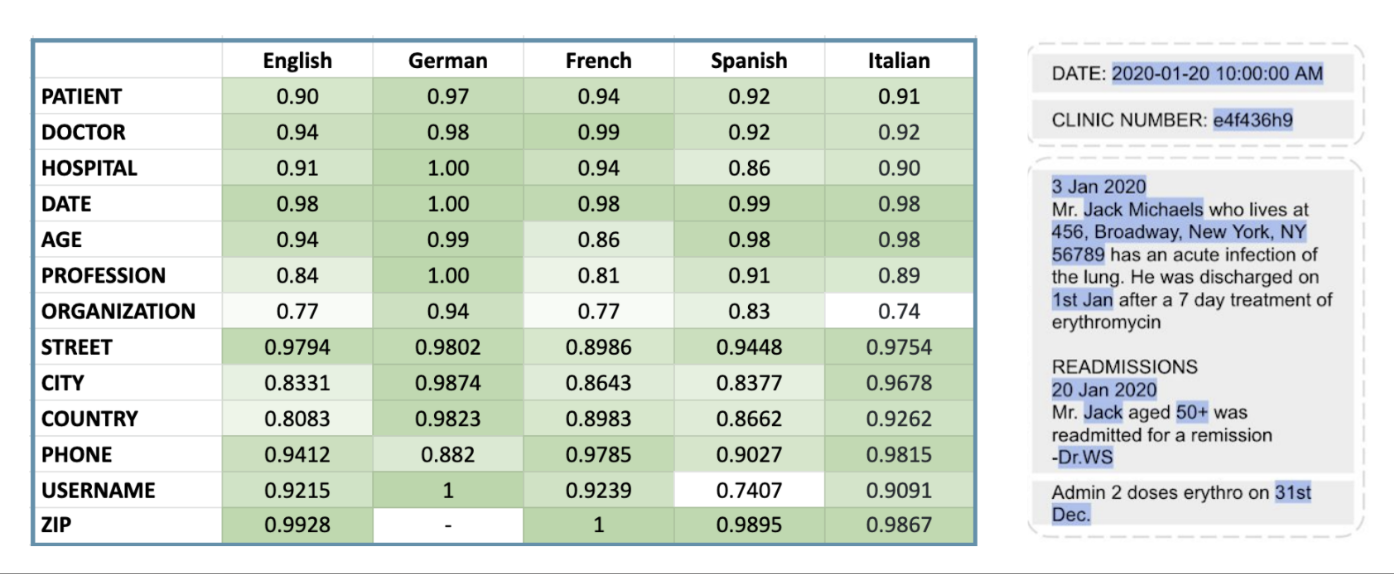

|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [bert_token_classifier_ner_deid]()| 2| [ner_deidentify_dl]()| 3| [ner_deid_subentity_glove]()|
| 4| [ner_deid_subentity_augmented_i2b2_pipeline]()| 5| [ner_deid_subentity_augmented_pipeline]()| 6| [ner_deid_sd]()|
| 7| [ner_deid_generic_augmented_pipeline]()| 8| [ner_deid_enriched_biobert]()| 9| [ner_deidentify_dl_pipeline]()|
| 10| [ner_deid_sd_large]()| 11| [ner_deid_enriched_pipeline]()| 12| [ner_deid_large]()|
| 13| [ner_deid_biobert_pipeline]()| 14| [ner_deid_subentity_augmented]()| 15| [bert_token_classifier_ner_deid_pipeline]()|
| 16| [ner_deid_sd_pipeline]()| 17| [ner_deid_biobert]()| 18| [ner_deid_enriched]()|
| 19| [ner_deid_synthetic]()| 20| [ner_deid_augmented]()| 21| [ner_deid_sd_large_pipeline]()|
| 22| [ner_deid_large_pipeline]()| 23| [ner_deid_enriched_biobert_pipeline]()| 24| [ner_deid_subentity_augmented_i2b2]()|
| 25| [ner_deid_augmented_pipeline]()| 26| [ner_deid_generic_glove]()| 27| []()|

|index| model                     |   language |index| model                     |   language |         
|----:|:-----------------------------------|--:|----:|:-----------------------------------|--:|
| 1|[ner_deid_generic]()                   | it| 2|[ner_deid_generic]()                   | es|
| 3|[ner_deid_subentity]()                 | it| 4|[ner_deid_generic_roberta]()           | es|
| 5|[ner_deid_generic]()                   | fr| 6|[ner_deid_generic_augmented]()         | es|
| 7|[ner_deid_subentity]()                 | fr| 8|[ner_deid_generic_roberta_augmented]() | es|
| 9|[	ner_deid_generic]()                  | de|10|[ner_deid_subentity]()                 | es|
|11|[ner_deid_generic_pipeline]()          | de|12|[ner_deid_subentity_roberta]()         | es|
|13|[ner_deid_subentity]()                 | de|14|[ner_deid_subentity_augmented]()       | es|
|15|[ner_deid_subentity_pipeline]()          | de|16|[ner_deid_subentity_roberta_augmented]()| es|

You can find German, Spanish, French, and Italian deidentification models and pretrained pipeline examples in these notebooks:


*   [Clinical Deidentification in German notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.1.Clinical_Deidentification_in_German.ipynb)
*   [Clinical Deidentification in Spanish notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.2.Clinical_Deidentification_in_Spanish.ipynb)
*   [Clinical Deidentification in French notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.5.Clinical_Deidentification_in_French.ipynb)
*   [Clinical Deidentification in Italian notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.6.Clinical_Deidentification_in_Italian.ipynb) 

Load NER pipeline to identify protected entities:

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)

clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

### Pretrained NER models extracts:

- Name
- Profession
- Age
- Date
- Contact(Telephone numbers, FAX numbers, Email addresses)
- Location (Address, City, Postal code, Hospital Name, Employment information)
- Id (Social Security numbers, Medical record numbers, Internet protocol addresses)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .
'''

In [ ]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result_df = result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

In [ ]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

### Check extracted sensetive entities

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

### Excluding entities from deidentification

Sometimes we need to leave some entities in the text, for example, if we want to analyze the frequency of the disease by the hospital. In this case, we need to use parameter **`setWhiteList()`** to modify `ner_chunk` output. This parameter having using a list of entities type to deidentify as an input. So, if we want to leave the location in the list we need to remove this tag from the list:

In [ ]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk") \
    .setWhiteList(['NAME', 'PROFESSION', 'ID', 'AGE', 'DATE'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_with_white_list = nlpPipeline.fit(empty_data)

In [ ]:
result_with_white_list = model_with_white_list.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
print("All Labels :")
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

print("WhiteListed Labels: ")
result_with_white_list.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
                      .select(F.expr("cols['0']").alias("chunk"),
                              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

## Masking and Obfuscation

### Replace this enitites with Tags

In [ ]:
ner_converter = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk") 

deidentification = DeIdentification() \
      .setInputCols(["sentence", "token", "ner_chunk"]) \
      .setOutputCol("deidentified") \
      .setMode("mask")\
      .setReturnEntityMappings(True) #  return a new column to save the mappings between the mask/obfuscated entities and original entities.
      #.setMappingsColumn("MappingCol") # change the name of the column, 'aux' is default

deidPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [ ]:
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result.show()

In [ ]:
result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

We have three modes to mask the entities in the Deidentification annotator. You can select the modes using the `.setMaskingPolicy()` parameter. The methods are the followings:

**“entity_labels”**: Mask with the entity type of that chunk. (default) <br/>
**“same_length_chars”**: Mask the deid entities with same length of asterix ( * ) with brackets ( [ , ] ) on both end. <br/>
**“fixed_length_chars”**: Mask the deid entities with a fixed length of asterix ( * ). The length is setting up using the `setFixedMaskLength()` method. <br/>
Let's try each of these and compare the results. 

In [ ]:
#deid model with "entity_labels"
deid_entity_labels= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_entity_label")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("entity_labels")

#deid model with "same_length_chars"
deid_same_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_same_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("same_length_chars")

#deid model with "fixed_length_chars"
deid_fixed_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_fixed_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("fixed_length_chars")\
    .setFixedMaskLength(4)


deidPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      deid_entity_labels,
      deid_same_length,
      deid_fixed_length])


empty_data = spark.createDataFrame([[""]]).toDF("text")
model_deid = deidPipeline.fit(empty_data)

In [ ]:
policy_result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
policy_result.show()

In [ ]:
policy_result.select(F.explode(F.arrays_zip('sentence.result', 
                                            'deid_entity_label.result', 
                                            'deid_same_length.result', 
                                            'deid_fixed_length.result')).alias("cols")) \
             .select(F.expr("cols['0']").alias("sentence"),
                     F.expr("cols['1']").alias("deid_entity_label"),
                     F.expr("cols['2']").alias("deid_same_length"),
                     F.expr("cols['3']").alias("deid_fixed_length")).toPandas()

### Mapping Column

In [ ]:
result.select("aux").show(truncate=False)

In [ ]:
result.select(F.explode(F.arrays_zip('aux.metadata', 'aux.result', 'aux.begin', 'aux.end')).alias("cols")) \
      .select(F.expr("cols['0']['originalChunk']").alias("chunk"),
              F.expr("cols['0']['beginOriginalChunk']").alias("beginChunk"),
              F.expr("cols['0']['endOriginalChunk']").alias("endChunk"),
              F.expr("cols['1']").alias("label"),
              F.expr("cols['2']").alias("beginLabel"),
              F.expr("cols['3']").alias("endLabel")).show(truncate=False)

## Reidentification

We can use `ReIdentification` annotator to go back to the original sentence.

In [ ]:
reIdentification = ReIdentification()\
    .setInputCols(["aux","deidentified"])\
    .setOutputCol("original")

In [ ]:
reid_result = reIdentification.transform(result)

In [ ]:
reid_result.show()

In [ ]:
print(text)

reid_result.select('original.result').show(truncate=False)

## Using multiple NER in the same pipeline

In [ ]:
from sparknlp_jsl.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_generic")

ner_converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner_generic"])\
    .setOutputCol("ner_generic_chunk")\
    .setWhiteList(['ID', 'DATE', 'AGE', 'NAME', 'PROFESSION'])# CONTACT and LOCATION is removed

deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverter() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\
    .setWhiteList(['COUNTRY', 'CITY', 'HOSPITAL', 'STATE', 'STREET', 'ZIP'])
    # we can also add PATIENT and DOCTOR entities and remove NAME entity from the other NER model

chunk_merge = ChunkMergeApproach()\
    .setInputCols("ner_subentity_chunk","ner_generic_chunk")\
    .setOutputCol("deid_merged_chunk")

deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "deid_merged_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setIgnoreRegex(True)


nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      deid_ner,
      ner_converter,
      deid_ner_enriched,
      ner_converter_enriched,
      chunk_merge,
      deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.
'''

In [ ]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

# ner_deid_generic_augmented
result.select(F.explode(F.arrays_zip('ner_generic_chunk.result', 'ner_generic_chunk.metadata')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

In [ ]:
# ner_deid_subentity_augmented
result.select(F.explode(F.arrays_zip('ner_subentity_chunk.result', 'ner_subentity_chunk.metadata')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

In [ ]:
# merged chunk
result.select(F.explode(F.arrays_zip('deid_merged_chunk.result', 'deid_merged_chunk.metadata')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

In [ ]:
result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

### Enriching with Regex and Override NER




In [ ]:
# PHONE

deidentification = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexOverride(True)

pipeline = Pipeline(stages=[
    nlpPipeline, 
    deidentification
])

model_default_rgx = pipeline.fit(empty_data)

In [ ]:
result = model_default_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

In [ ]:
rgx = '''NUMBER ([0-9]{2})
NUMBER (\d{7})''' 

with open("./custom_regex.txt", "w") as f:
  f.write(rgx)

f = open("./custom_regex.txt", "r")

print(f.read())

We see that two entities  have conflict between the regex and the NER. NER has the priroty as a default. We can change this `setRegexOverride` param 

In [ ]:
deidentification_rgx = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexPatternsDictionary("./custom_regex.txt")\
    .setRegexOverride(True)


nlpPipeline_rgx = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner,
    ner_converter,
    deid_ner_enriched,
    ner_converter_enriched,
    chunk_merge,
    deidentification_rgx])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_rgx = nlpPipeline_rgx.fit(empty_data)

In [ ]:
text ='''Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street.'''

result = model_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

`.setBlackList()` parameter so that not deidentifiy the labels that are specified in the list. This parameter filters just the detected Regex Entities.  

In [ ]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["NAME", "LOCATION"])

# DATE, PHONE, URL, EMAIL, ZIP, DATE, SSN, PASSPORT, DLN, NPI, C_CARD, EMAIL, IBAN, DEA
deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setRegexOverride(True)\
    .setBlackList(["DATE", "PHONE"])

deidPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street. Phone (302) 786-5227.
'''
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

## Obfuscation mode

In the obfuscation mode **DeIdentificationModel** will replace sensetive entities with random values of the same type. 


In [ ]:
obs_lines = """Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Ekaterina Rosa#DOCTOR
Rudiger Chao#DOCTOR
COLLETTE KOHLER#DOCTOR
Mufi HIGGS#DOCTOR"""


with open ('obfuscation.txt', 'w') as f:
  f.write(obs_lines)

In [ ]:
deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverter() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    #.setObfuscateRefFile('obfuscation.txt')\
    #.setObfuscateRefSource("both") #default: "faker"

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

In [ ]:
result.select("ner_subentity_chunk").collect()

In [ ]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefFile('obfuscation.txt')\
    .setObfuscateRefSource("file")

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)      
      
      
result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

## Faker mode

The faker module allow to the user to use a set of fake entities that are in the memory of the spark-nlp-internal. You can setting up this module using the the following property setObfuscateRefSource('faker').

If we select the setObfuscateRefSource('both') then we choose randomly the entities using the faker and the fakes entities from the obfuscateRefFile.


The entities that are allowed right now are the followings:

* Location
* Location-other
* Hospital
* City
* State
* Zip
* Country
* Contact
* Username
* Phone
* Fax
* Url
* Email
* Profession
* Name
* Doctor
* Patient
* Id
* Idnum
* Bioid
* Age
* Organization
* Healthplan
* Medicalrecord
* Ssn
* Passport
* DLN
* NPI
* C_card
* IBAN
* DEA
* Device




In [ ]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

## Use full pipeline in the Light model

In [ ]:
light_model = LightPipeline(model)
annotated_text = light_model.annotate(text)
annotated_text['deidentified']

In [ ]:
obf_light_model = LightPipeline(obfuscation_model)
annotated_text = obf_light_model.annotate(text)
annotated_text['deidentified']

# Structured Deidentification

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/hipaa-table-001.txt

df = spark.read.format("csv") \
    .option("sep", "\t") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load("hipaa-table-001.txt")

df = df.withColumnRenamed("PATIENT","NAME")
df.show(truncate=False)

In [ ]:
from sparknlp_jsl.structured_deidentification import StructuredDeidentification

In [ ]:
obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, obfuscateRefSource = "faker")
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.show(truncate=False)

In [ ]:
obfuscator_unique_ref_test = '''Will Perry#PATIENT
John Smith#PATIENT
Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Jackson WILLE#PATIENT
Jack SANTOS#PATIENT
Mahmood ALBURN#PATIENT
Marnie MELINGTON#PATIENT
Aysha GHAZI#PATIENT
Maryland CODER#PATIENT
Darene GEORGIOUS#PATIENT
Shelly WELLBECK#PATIENT
Min Kun JAE#PATIENT
Thomson THOMAS#PATIENT
Christian SUDDINBURG#PATIENT
Aberdeen#CITY
Louisburg St#STREET
France#LOC
Nick Riviera#DOCTOR
5552312#PHONE
St James Hospital#HOSPITAL
Calle del Libertador#ADDRESS
111#ID
Will#DOCTOR
20#AGE
30#AGE
40#AGE
50#AGE
60#AGE
'''

with open('obfuscator_unique_ref_test.txt', 'w') as f:
  f.write(obfuscator_unique_ref_test)

In [ ]:
# obfuscateRefSource = "file"

obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, 
                                        obfuscateRefFile = "/content/obfuscator_unique_ref_test.txt",
                                        obfuscateRefSource = "file",
                                        columnsSeed={"NAME": 23, "AGE": 23})
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.select("NAME","AGE").show(truncate=False)

We can **shift n days** in the structured deidentification through "days" parameter when the column is a Date.

In [ ]:
df = spark.createDataFrame([
            ["Juan García", "13/02/1977", "711 Nulla St.", "140", "673 431234"],
            ["Will Smith", "23/02/1977", "1 Green Avenue.", "140", "+23 (673) 431234"],
            ["Pedro Ximénez", "11/04/1900", "Calle del Libertador, 7", "100", "912 345623"]
        ]).toDF("NAME", "DOB", "ADDRESS", "SBP", "TEL")
df.show(truncate=False)

In [ ]:
obfuscator = StructuredDeidentification(spark=spark, 
                                        columns={"NAME": "ID", "DOB": "DATE"},
                                        columnsSeed={"NAME": 23, "DOB": 23},
                                        obfuscateRefSource="faker",
                                        days=5
                                         )

In [ ]:
result = obfuscator.obfuscateColumns(df)
result.show(truncate=False)

# Pretrained Deidentification Pipeline

This pipeline can be used to deidentify PHI information from medical texts. The PHI information will be masked and obfuscated in the resulting text. The pipeline can mask and obfuscate `AGE`, `CONTACT`, `DATE`, `ID`, `LOCATION`, `NAME`, `PROFESSION`, `CITY`, `COUNTRY`, `DOCTOR`, `HOSPITAL`, `IDNUM`, `MEDICALRECORD`, `ORGANIZATION`, `PATIENT`, `PHONE`, `PROFESSION`, `STREET`, `USERNAME`, `ZIP`, `ACCOUNT`, `LICENSE`, `VIN`, `SSN`, `DLN`, `PLATE`, `IPADDR` entities.

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification", "en", "clinical/models")

In [ ]:
deid_pipeline.model.stages

In [ ]:
text= """Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435. Dr. John Green, ID: 1231511863, IP 203.120.223.13. He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93. Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B. Phone (302) 786-5227, 0295 Keats Street, San Francisco, E-MAIL: smith@gmail.com"""

In [ ]:
deid_res= deid_pipeline.annotate(text)

In [ ]:
deid_res.keys()

In [ ]:
pd.set_option("display.max_colwidth", 100)

df= pd.DataFrame(list(zip(deid_res["sentence"], 
                          deid_res["masked"],
                          deid_res["masked_with_chars"],
                          deid_res["masked_fixed_length_chars"], 
                          deid_res["obfuscated"])),
                 columns= ["Sentence", "Masked", "Masked with Chars", "Masked with Fixed Chars", "Obfuscated"])

df